## Simple XGBoost tutorial


We will use the trivial **Iris Dataset** which you can get from directly from sklearn or from the UCI repository.

First of all, let's import what is needed:

In [1]:
import numpy as np
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split

Load the Iris dataset and split in train and test following the thumb rule of 80/20:

In [2]:
iris = datasets.load_iris()
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [3]:
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Use **DMatrix** as data structures for both train and test. 

DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed.
You can construct DMatrix from numpy.arrays:

In [4]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

Set XGBoost parameters:

merror: Multiclass classification error rate. It is calculated as #(wrong cases)/#(all cases).

In [5]:
params = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # step for each iteration
    'silent': 1, # keep it quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3, # the number of classes 
    'eval_metric': 'merror'} # evaluation metric 

num_round = 20  # the number of training iterations (number of trees)

Create a model and fit it with params:

(We could have used also XGBClassifier, which is a scikit-learn compatible class. It is basically just a wrapper over the xgb.train function).

In [6]:
model = xgb.train(params,
                  dtrain,
                  num_round,
                  verbose_eval=2,
                  evals=[(dtrain, 'train')])

[0]	train-merror:0.016667
[2]	train-merror:0.016667
[4]	train-merror:0.016667
[6]	train-merror:0.016667
[8]	train-merror:0.016667
[10]	train-merror:0.016667
[12]	train-merror:0.016667
[14]	train-merror:0.016667
[16]	train-merror:0.016667
[18]	train-merror:0.008333
[19]	train-merror:0.008333


In [7]:
from sklearn.metrics import precision_score

preds = model.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])
print("Precision: {:.2f} %".format(precision_score(y_test, best_preds, average='macro')))

Precision: 0.95 %


It is possible to show with an histogram the importance of each feature:

In [8]:
%matplotlib inline
from xgboost import plot_importance

**Gain:** it implies the relative contribution of the corresponding feature to the model calculated by taking each feature's contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.

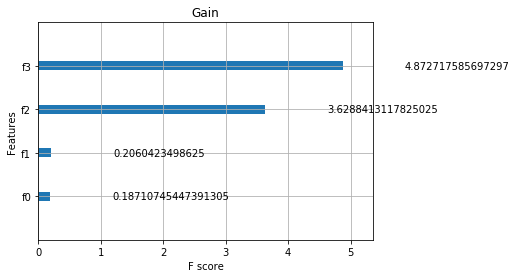

In [9]:
plot_importance(model, importance_type='gain', title='Gain')

**Cover:** The Cover metric means the relative number of observations related to this feature. Therefore is the number of observations for which the leaf node is determined by the feature. This number will be calculated for all the features in the dataset and the cover will be expressed as a percentage over all features' cover metrics.

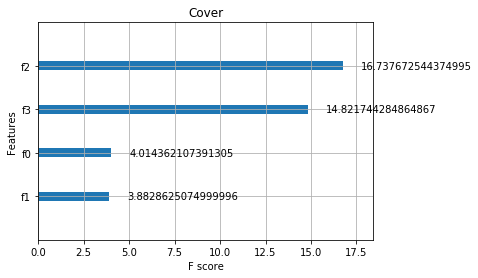

In [10]:
plot_importance(model, importance_type='cover', title='Cover')

**Weight (Frequence):** is the percentage representing the relative number of times a particular feature occurs in the trees of the model. Is the number of splits in which the particular feature occurred.

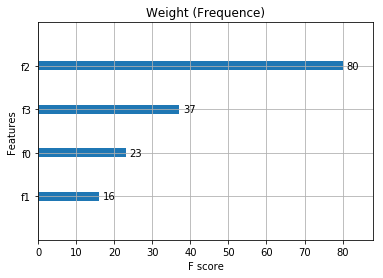

In [11]:
plot_importance(model, importance_type='weight', title='Weight (Frequence)')

In order to avoid overfitting, we can use the early stopping technique looking at the error on our local validation set. Let's try it:

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=3)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [13]:
model = xgb.train(params,
                  dtrain,
                  num_round,
                  verbose_eval=2,
                  evals=[(dtrain, 'train'), (dval, 'validation')],
                  early_stopping_rounds=20)

[0]	train-merror:0.020833	validation-merror:0
Multiple eval metrics have been passed: 'validation-merror' will be used for early stopping.

Will train until validation-merror hasn't improved in 20 rounds.
[2]	train-merror:0.020833	validation-merror:0
[4]	train-merror:0.020833	validation-merror:0
[6]	train-merror:0.010417	validation-merror:0.041667
[8]	train-merror:0.010417	validation-merror:0.041667
[10]	train-merror:0	validation-merror:0.083333
[12]	train-merror:0	validation-merror:0.041667
[14]	train-merror:0	validation-merror:0.083333
[16]	train-merror:0	validation-merror:0.083333
[18]	train-merror:0	validation-merror:0.083333
[19]	train-merror:0	validation-merror:0.083333


### If we plot the precision and feature weight we may see changes in the values

In [14]:
preds = model.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])
print("Precision: {:.2f} %".format(precision_score(y_test, best_preds, average='macro')))

Precision: 0.95 %


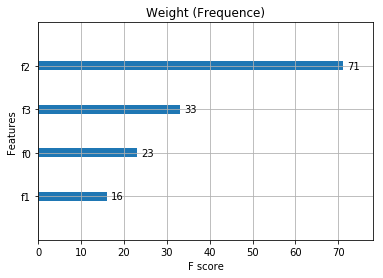

In [15]:
plot_importance(model, importance_type='weight', title='Weight (Frequence)')

## How to use XGBoost in RecSys?

## Hint: reranking and hybridization

### Steps:
* Run your best algorithm and select a number of recommendations higher than the target cutoff, for example if you have to compute MAP@10, get 20 recommendations
* Build a dataframe whose samples are the user-item recommendations
* Add for each interaction some content features: item features, user features
* Add for each interaction some features derived by other algorithms: CBF prediction, hybrid prediction
* Add for each interaction other miscellaneous information: profile length, item popularity ..

## Dummy example

In [16]:
from urllib.request import urlretrieve
import zipfile

# skip the download
#urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", "movielens_10m.zip")
dataFile = zipfile.ZipFile("movielens_10m.zip")
URM_path = dataFile.extract("ml-10M100K/ratings.dat")
URM_file = open(URM_path, 'r')


def rowSplit (rowString):
    
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = float(split[2])
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result


URM_file.seek(0)
URM_tuples = []

for line in URM_file:
   URM_tuples.append(rowSplit (line))

userList, itemList, ratingList, timestampList = zip(*URM_tuples)

userList = list(userList)
itemList = list(itemList)
ratingList = list(ratingList)
timestampList = list(timestampList)

import scipy.sparse as sps

URM_all = sps.coo_matrix((ratingList, (userList, itemList)))
URM_all = URM_all.tocsr()



from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample


URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)

In [17]:
ICM_path = dataFile.extract("ml-10M100K/tags.dat", path = "data/Movielens_10M")
ICM_file = open(ICM_path, 'r')

def rowSplit (rowString):
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = str(split[2]) # tag is a string, not a float like the rating
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result

ICM_file.seek(0)
ICM_tuples = []

for line in ICM_file:
    ICM_tuples.append(rowSplit(line))
    
userList_icm, itemList_icm, tagList_icm, timestampList_icm = zip(*ICM_tuples)

userList_icm = list(userList_icm)
itemList_icm = list(itemList_icm)
tagList_icm = list(tagList_icm)
timestampList_icm = list(timestampList_icm)

userList_unique = list(set(userList_icm))
itemList_unique = list(set(itemList_icm))
tagList_unique = list(set(tagList_icm))

numUsers = len(userList_unique)
numItems = len(itemList_unique)
numTags = len(tagList_unique)


print ("Number of items\t {}, Number of users\t {}".format(numItems, numUsers))
print ("Number of tags\t {}, Number of item-tag tuples {}".format(numTags, len(tagList_icm)))

print("\nData example:")
print(userList_icm[0:10])
print(itemList_icm[0:10])
print(tagList_icm[0:10])


from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(tagList_icm)

tagList_icm = le.transform(tagList_icm)

import numpy as np

ones = np.ones(len(tagList_icm))

ICM_all = sps.coo_matrix((ones, (itemList_icm, tagList_icm)), shape=(URM_all.shape[1], tagList_icm.max()+1))
ICM_all = ICM_all.tocsr()

Number of items	 7601, Number of users	 4009
Number of tags	 16529, Number of item-tag tuples 95580

Data example:
[15, 20, 20, 20, 20, 20, 20, 20, 20, 20]
[4973, 1747, 1747, 2424, 2424, 2424, 2947, 2947, 3033, 3033]
['excellent!', 'politics', 'satire', 'chick flick 212', 'hanks', 'ryan', 'action', 'bond', 'spoof', 'star wars']


In [18]:
class MyBestHybrid_Recommender(object):
    
    def __init__(self, URM):
        
        self.URM = URM
        self.n_users, self.n_items = URM.shape
        
        
    def fit(self):
        pass
    
    def recommend(self, user_id, cutoff = 5, exclude_seen=True):
        
        user_profile = self.URM[user_id]
        
        ranking = np.random.choice(self.n_items, cutoff)
            
        return ranking
        

In [19]:
n_users, n_items = URM_train.shape

In [20]:
dummyHybridRecommender = MyBestHybrid_Recommender(URM_train)
dummyHybridRecommender.fit()

## Build the dataframe with the predictions



In [21]:
cutoff = 20
user_recommendations_items = []
user_recommendations_user_id = []

for n_user in range(100):
    
    recommendations = dummyHybridRecommender.recommend(n_user, cutoff = 20)
    
    user_recommendations_items.extend(recommendations)
    user_recommendations_user_id.extend([n_user]*len(recommendations))
    
    

In [22]:
user_recommendations_items

[53639,
 10643,
 20615,
 5706,
 39938,
 52052,
 488,
 16342,
 23523,
 38284,
 13809,
 42227,
 26351,
 31157,
 59947,
 64169,
 40624,
 55150,
 31262,
 15222,
 36138,
 54264,
 21625,
 59519,
 25389,
 44537,
 49690,
 32351,
 20547,
 38629,
 59107,
 57897,
 49923,
 44204,
 37193,
 45808,
 33397,
 44330,
 36206,
 31101,
 27697,
 48163,
 51181,
 17255,
 11580,
 51042,
 51841,
 36011,
 135,
 52054,
 40049,
 28054,
 49409,
 36178,
 8057,
 58374,
 35126,
 17436,
 9151,
 49826,
 32170,
 38846,
 55358,
 56793,
 17952,
 43513,
 6871,
 23124,
 56277,
 34882,
 33599,
 57798,
 29715,
 26327,
 63377,
 44346,
 15161,
 62598,
 62724,
 60546,
 32728,
 12877,
 37019,
 13379,
 34954,
 22116,
 3089,
 16088,
 15778,
 55515,
 13692,
 32284,
 47187,
 47392,
 55891,
 29206,
 20297,
 11362,
 28873,
 45383,
 42631,
 7921,
 24678,
 3241,
 9200,
 32692,
 56627,
 20790,
 13315,
 27369,
 360,
 16236,
 41707,
 8476,
 47476,
 8068,
 51608,
 61376,
 11911,
 56830,
 45844,
 18629,
 22274,
 32543,
 31621,
 11089,
 39445,


In [23]:
user_recommendations_user_id

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,


In [24]:

import pandas as pd

train_dataframe = pd.DataFrame({"user_id":user_recommendations_user_id, "item_id":user_recommendations_items})
train_dataframe

,user_id,item_id
0,0,53639
1,0,10643
2,0,20615
3,0,5706
4,0,39938
5,0,52052
6,0,488
7,0,16342
8,0,23523
9,0,38284


## Now let's add some features. For example, the prediction of another algorithm


In [25]:
from Base.NonPersonalizedRecommender import TopPop

topPop = TopPop(URM_train)
topPop.fit()


topPop_score_list = []

for user_id, item_id in zip(user_recommendations_user_id, user_recommendations_items):
    
    topPop_score = topPop.compute_score_top_pop([user_id])[0,item_id]
    topPop_score_list.append(topPop_score)
    

In [26]:
train_dataframe['item_popularity'] = pd.Series(topPop_score_list, index=train_dataframe.index)
train_dataframe

,user_id,item_id,item_popularity
0,0,53639,0.0
1,0,10643,0.0
2,0,20615,0.0
3,0,5706,6.0
4,0,39938,0.0
5,0,52052,0.0
6,0,488,175.0
7,0,16342,0.0
8,0,23523,0.0
9,0,38284,0.0


## Or the profile length

In [27]:
user_profile_len = np.ediff1d(URM_train.indptr)

In [28]:
user_profile_len_list = []

target_feature = 1

for user_id, item_id in zip(user_recommendations_user_id, user_recommendations_items):
    
    user_profile_len_list.append(user_profile_len[user_id])
    

In [29]:
train_dataframe['user_profile_len'] = pd.Series(user_profile_len_list, index=train_dataframe.index)
train_dataframe

,user_id,item_id,item_popularity,user_profile_len
0,0,53639,0.0,0
1,0,10643,0.0,0
2,0,20615,0.0,0
3,0,5706,6.0,0
4,0,39938,0.0,0
5,0,52052,0.0,0
6,0,488,175.0,0
7,0,16342,0.0,0
8,0,23523,0.0,0
9,0,38284,0.0,0


## the same can be done with item features



In [30]:
feature_1_list = []

target_feature = 1

for user_id, item_id in zip(user_recommendations_user_id, user_recommendations_items):
    
    item_features = ICM_all[item_id,:]
    
    if target_feature in item_features.indices:
        feature_1_list.append(1)
    else:
        feature_1_list.append(0)    
    
    

In [31]:
train_dataframe['item_feature_1'] = pd.Series(feature_1_list, index=train_dataframe.index)
train_dataframe

,user_id,item_id,item_popularity,user_profile_len,item_feature_1
0,0,53639,0.0,0,0
1,0,10643,0.0,0,0
2,0,20615,0.0,0,0
3,0,5706,6.0,0,0
4,0,39938,0.0,0,0
5,0,52052,0.0,0,0
6,0,488,175.0,0,0
7,0,16342,0.0,0,0
8,0,23523,0.0,0,0
9,0,38284,0.0,0,0


## Then you can train XGBoost to rerank those prediction using as lable whether they should be recommended or not